## resampling
큰 향상 없음
- oversampling
  - SMOTE acc = 87.9%
- undersampling
  - InstanceHardnessThreshold acc = 85%
- combined 
  - SMOTETomek acc = 87.4%

- 정확도 향상에는 크게 기여하지 않았으나 minority class  recall, precision 향상됨
- 데이터 셋 내 자체에 잘못 라벨링 된 데이터가 확인 필요

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

def train_test_val_split(path, val_frac=0.2,test_frac=0.5):
  """Pose estimator에서 나온 데이터셋을 랜덤하게 층화 추출하여 모델 학습용, 검정용, 테스트용으로 나눈다.
  
  Returns:
    X_train: 학습용 데이터셋으로 기본값으로 80%비율을 갖는다.
    X_test: 테스트용 데이터셋으로 기본값으로 10%비율을 갖는다.
    X_val: 검정용 데이터셋으로 기본값으로 10%비율을 갖는다.
    y_train: 학습용 데이터셋의 정답값으로 기본값으로 80%비율을 갖는다.
    y_test: 테스트용 데이터셋의 정답값으로 기본값으로 10%비율을 갖는다.
    y_val: 검정용 데이터셋의 정답값으로 기본값으로 10%비율을 갖는다.
    class_names: 인덱스와 해당 하는 클래스 이름을 리턴한다.
    image_path_df: 인덱스와 해당 하는 이미지 저장 위치를 리턴한다.
      truth labels (y) to use later to train a pose classification model.
  """
  
  dataframe = pd.read_csv(path, index_col=0)
  dataframe.reset_index()
  df_to_process = dataframe.copy()
  image_path_df=df_to_process[['file_name']]
  df_to_process.drop(columns=['file_name'], inplace=True)
  classes = df_to_process['class_name'].unique()

  for i in range(len(classes)):
    df_to_process.loc[df_to_process['class_name']==classes[i],'class_no']=i
  classes = df_to_process.pop('class_name').unique()

  y = df_to_process.pop('class_no')
  
  X = df_to_process.astype('float64')

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_frac,shuffle=True,stratify=y)
  if test_frac==0:
    y_train = tf.keras.utils.to_categorical(y_train)
    y_val = tf.keras.utils.to_categorical(y_val)
    y_test=0
    X_test=0
  else:
    X_val, X_test, y_val, y_test= train_test_split(X_val, y_val, test_size=test_frac,shuffle=True,stratify=y_val)
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    y_val = tf.keras.utils.to_categorical(y_val)
  return  X_train,  X_test, X_val,y_train, y_test, y_val,classes,image_path_df

X_train,  X_test, X_val,y_train, y_test, y_val,class_names,image_path_df= df_to_process=train_test_val_split( '/content/drive/MyDrive/ai_trainer/kp_processed/81poses.csv',val_frac=0.1,test_frac=.0)

1. over-sampling

In [13]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')
X_sm,y_sm =smote.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


((14653, 51), (14653, 81))

In [21]:
from tensorflow import keras
classes=len(class_names)
inputs = tf.keras.Input(shape=(51))

layer = tf.keras.layers.Reshape((17, 3))(inputs) #51->17,3
layer = tf.keras.layers.LayerNormalization(axis=1)(layer[:, :, :2])  #17,3 ->17,2
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense( classes, activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = f"/content/drive/MyDrive/ai_trainer/models/simplednn_smote{len(class_names)}_weights2.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(X_sm,y_sm ,
                    epochs=250,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/250
913/916 [============================>.] - ETA: 0s - loss: 3.4641 - accuracy: 0.1657
Epoch 1: val_accuracy improved from -inf to 0.47680, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2.best.hdf5
916/916 [==============================] - 6s 5ms/step - loss: 3.4621 - accuracy: 0.1658 - val_loss: 2.1595 - val_accuracy: 0.4768
Epoch 2/250
911/916 [============================>.] - ETA: 0s - loss: 2.3494 - accuracy: 0.3615
Epoch 2: val_accuracy improved from 0.47680 to 0.64844, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2.best.hdf5
916/916 [==============================] - 3s 3ms/step - loss: 2.3483 - accuracy: 0.3620 - val_loss: 1.4653 - val_accuracy: 0.6484
Epoch 3/250
905/916 [============================>.] - ETA: 0s - loss: 1.9519 - accuracy: 0.4548
Epoch 3: val_accuracy improved from 0.64844 to 0.69358, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2.best.hdf5


In [29]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('not majority')
X_sm,y_sm =smote.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


((41958, 51), (41958, 81))

In [31]:
from tensorflow import keras
classes=len(class_names)
inputs = tf.keras.Input(shape=(51))

layer = tf.keras.layers.Reshape((17, 3))(inputs) #51->17,3
layer = tf.keras.layers.LayerNormalization(axis=1)(layer[:, :, :2])  #17,3 ->17,2
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense( classes, activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = f"/content/drive/MyDrive/ai_trainer/models/simplednn_smote{len(class_names)}_weights2.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(X_sm,y_sm ,
                    epochs=250,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/250
2620/2623 [============================>.] - ETA: 0s - loss: 2.6438 - accuracy: 0.2869
Epoch 1: val_accuracy improved from -inf to 0.68976, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2.best.hdf5
2623/2623 [==============================] - 11s 4ms/step - loss: 2.6430 - accuracy: 0.2871 - val_loss: 1.3064 - val_accuracy: 0.6898
Epoch 2/250
2614/2623 [============================>.] - ETA: 0s - loss: 1.6534 - accuracy: 0.5152
Epoch 2: val_accuracy improved from 0.68976 to 0.72600, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2.best.hdf5
2623/2623 [==============================] - 7s 3ms/step - loss: 1.6526 - accuracy: 0.5154 - val_loss: 1.0495 - val_accuracy: 0.7260
Epoch 3/250
2605/2623 [============================>.] - ETA: 0s - loss: 1.4458 - accuracy: 0.5751
Epoch 3: val_accuracy improved from 0.72600 to 0.76160, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_smote81_weights2

2. under sampling

In [47]:

from imblearn.under_sampling import InstanceHardnessThreshold

iht = InstanceHardnessThreshold(sampling_strategy='majority',cv=5)
X_resampled, y_resampled = iht.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=all as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [48]:
X_resampled.shape ,y_resampled.shape

((13663, 51), (13663, 81))

In [50]:
classes=len(class_names)
inputs = tf.keras.Input(shape=(51))

layer = tf.keras.layers.Reshape((17, 3))(inputs) #51->17,3
layer = tf.keras.layers.LayerNormalization(axis=1)(layer[:, :, :2])  #17,3 ->17,2
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense( classes, activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = f"/content/drive/MyDrive/ai_trainer/models/simplednn_under{len(class_names)}_weights2.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(X_resampled,y_resampled ,
                    epochs=250,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/250
852/854 [============================>.] - ETA: 0s - loss: 3.4001 - accuracy: 0.1664
Epoch 1: val_accuracy improved from -inf to 0.50731, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_under81_weights2.best.hdf5
854/854 [==============================] - 9s 8ms/step - loss: 3.3983 - accuracy: 0.1667 - val_loss: 2.1639 - val_accuracy: 0.5073
Epoch 2/250
841/854 [============================>.] - ETA: 0s - loss: 2.3127 - accuracy: 0.3627
Epoch 2: val_accuracy improved from 0.50731 to 0.61093, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_under81_weights2.best.hdf5
854/854 [==============================] - 2s 3ms/step - loss: 2.3106 - accuracy: 0.3630 - val_loss: 1.5142 - val_accuracy: 0.6109
Epoch 3/250
837/854 [============================>.] - ETA: 0s - loss: 1.9402 - accuracy: 0.4632
Epoch 3: val_accuracy improved from 0.61093 to 0.65353, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_under81_weights2.best.hdf5


3. combined

In [34]:
import matplotlib.pyplot as plt

In [36]:

from imblearn.combine import SMOTETomek 

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)
X_res.shape, y_res.shape

((41744, 51), (41744, 81))

In [40]:

from imblearn.combine import SMOTETomek 

smt = SMOTETomek('all')
X_res, y_res = smt.fit_resample(X_train, y_train)
X_res.shape, y_res.shape

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=all as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


((41734, 51), (41734, 81))

In [41]:
from tensorflow import keras
classes=len(class_names)
inputs = tf.keras.Input(shape=(51))

layer = tf.keras.layers.Reshape((17, 3))(inputs) #51->17,3
layer = tf.keras.layers.LayerNormalization(axis=1)(layer[:, :, :2])  #17,3 ->17,2
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense( classes, activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = f"/content/drive/MyDrive/ai_trainer/models/simplednn_combined{len(class_names)}_weights2.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(X_sm,y_sm ,
                    epochs=250,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/250
2619/2623 [============================>.] - ETA: 0s - loss: 2.6346 - accuracy: 0.2876
Epoch 1: val_accuracy improved from -inf to 0.67832, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_combined81_weights2.best.hdf5
2623/2623 [==============================] - 10s 3ms/step - loss: 2.6333 - accuracy: 0.2879 - val_loss: 1.2993 - val_accuracy: 0.6783
Epoch 2/250
2618/2623 [============================>.] - ETA: 0s - loss: 1.6438 - accuracy: 0.5150
Epoch 2: val_accuracy improved from 0.67832 to 0.74062, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_combined81_weights2.best.hdf5
2623/2623 [==============================] - 7s 3ms/step - loss: 1.6436 - accuracy: 0.5150 - val_loss: 1.0189 - val_accuracy: 0.7406
Epoch 3/250
2620/2623 [============================>.] - ETA: 0s - loss: 1.4334 - accuracy: 0.5832
Epoch 3: val_accuracy improved from 0.74062 to 0.79530, saving model to /content/drive/MyDrive/ai_trainer/models/simplednn_combined81

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                                                                            precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       1.00      0.67      0.80         3
                             Bharadvaja's_Twist_pose_or_Bharadvajasana_I_       1.00      0.20      0.33         5
                                         Boat_Pose_or_Paripurna_Navasana_       0.87      0.90      0.89        30
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.63      0.86      0.73        22
                                                 Bow_Pose_or_Dhanurasana_       0.80      0.94      0.86        17
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       0.83      1.00      0.91        25
                                                 Camel_Pose_or_Ustrasana_       1.00      1.00      1.00        31
                                            Cat_Cow_Po

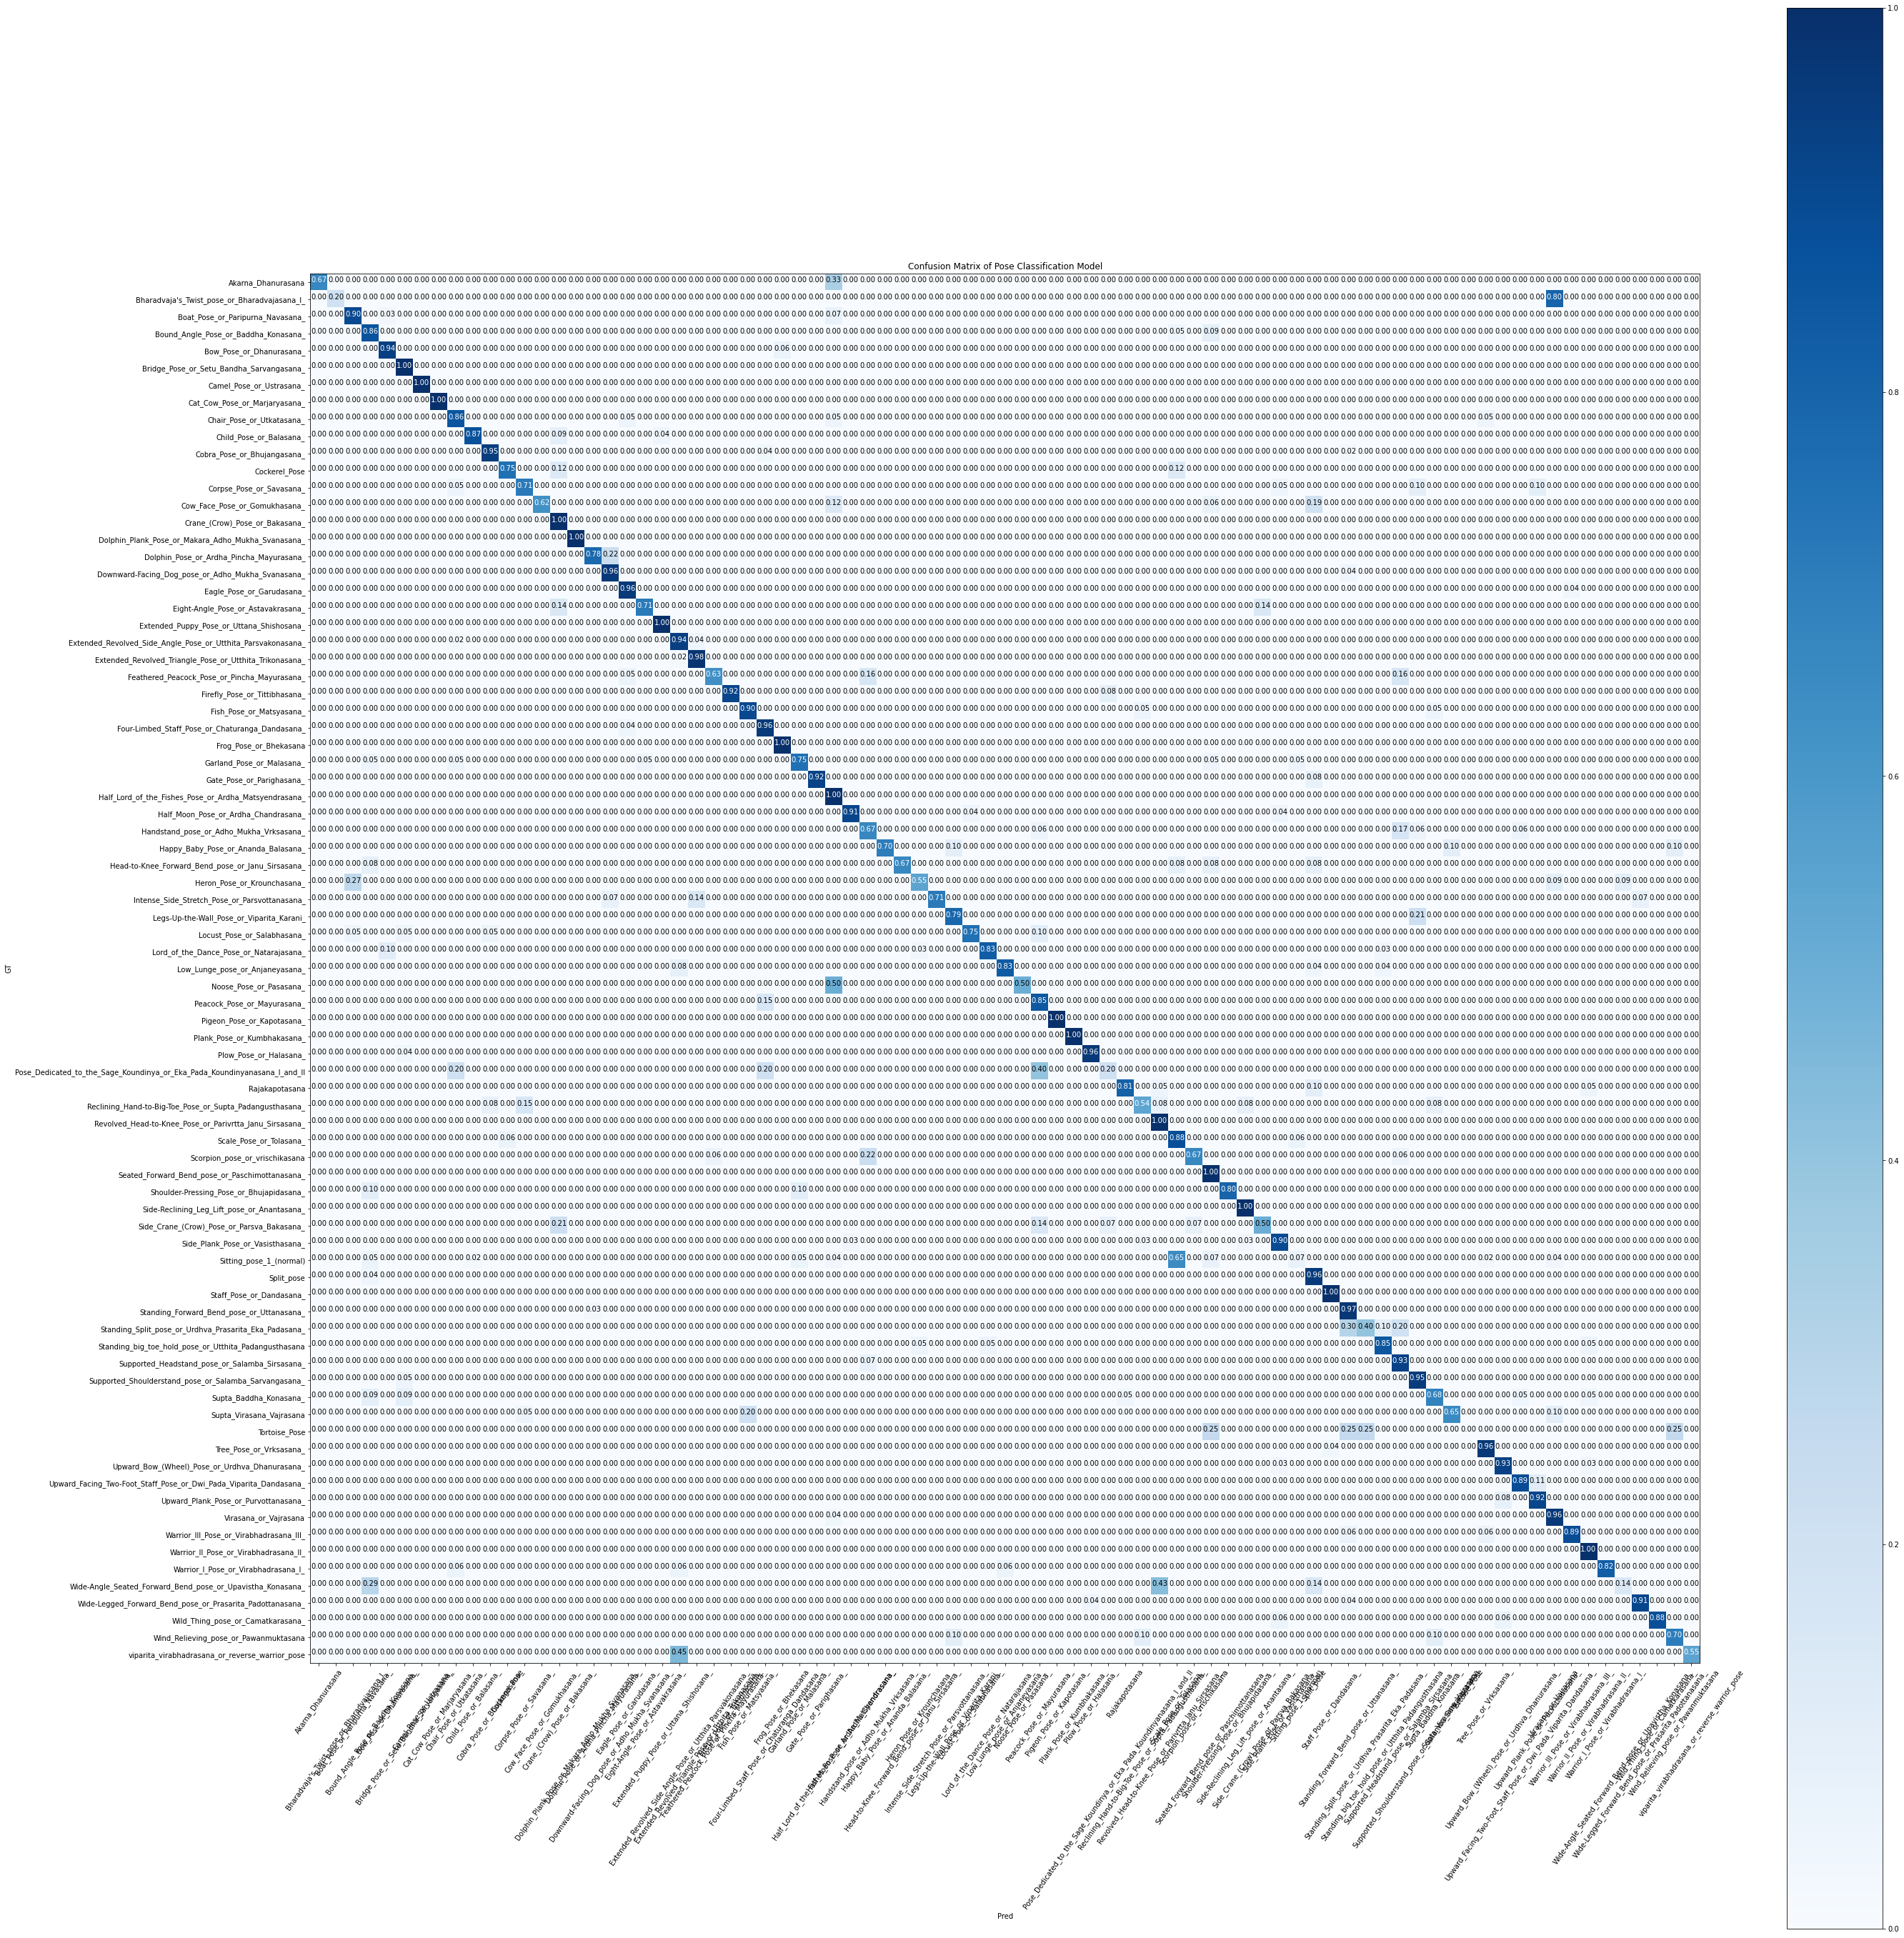

In [59]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(40,40))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('GT')
  plt.xlabel('Pred')
  plt.tight_layout()

y_pred = model.predict(X_val)
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_val, axis=1)]

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))